# Imports

In [1]:
%reload_ext autoreload
%autoreload 2
import matplotlib
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator

%run ../../setup_project.py
%run ../../generic_plot_functions.py
%run functions.py

import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.collections import LineCollection

In [2]:
projectName, dataPath, dlcModelPath, myProject, sSessions = setup_project_session_lists(projectName="autopi_mec",dataPath=PROJECT_DATA_PATH,dlcModelPath="")

creating myProject, an autopipy.project object
Project name: autopi_mec
dataPath: /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt/
dlcModelPath: 
Reading /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt//sessionList
We have 180 testing sessions in the list
spikeA.Kilosort_session objects are in sSessions


# Data

In [7]:
fn = myProject.dataPath + '/results/behavior_180_EastReferenceQuadrant.csv'
res = pd.read_csv(fn)
res=res[res.valid]

In [8]:
fn = myProject.dataPath + '/results/allSessionDf_with_leverVector_and_last_cohort.csv'
allSessionDf = pd.read_csv(fn,index_col=0)
allSessionDf['light'] = allSessionDf['condition'].apply(lambda x: x.split('_')[1])
allSessionDf['cond_noLight'] = allSessionDf['condition'].apply(lambda x: x.split('_')[0])

# Functions

In [9]:
def compute_lever_adjusted_time(inputDf):
    
    # Ensure the DataFrame is sorted to identify the first occurrence correctly
    inputDf_sorted = inputDf.sort_values(['session', 'condition', 'trialNo', 'withinPathTime'])
    
    # Create a mask where leverDistance < 5
    mask = inputDf_sorted['leverDistance'] < 5
    
    # Use groupby to find the first 'withinPathTime' where 'leverDistance' < 5 for each group
    time_shift = inputDf_sorted[mask].groupby(['session', 'condition', 'trialNo'])['withinPathTime'].first()
    
    # Merge the time_shift back to the original DataFrame
    adjusted_df = inputDf_sorted.merge(
        time_shift.rename('time_shift'), 
        on=['session', 'condition', 'trialNo'], 
        how='left'
    )
    
    # Drop groups where no 'leverDistance' < 5 was found (time_shift is NaN)
    adjusted_df = adjusted_df.dropna(subset=['time_shift']).copy()
    
    # Calculate the adjusted 'withinPathTime'
    adjusted_df['withinPathTimeAdj'] = adjusted_df['withinPathTime'] - adjusted_df['time_shift']
    
    # Optionally, drop the 'time_shift' column if it's no longer needed
    adjusted_df.drop(columns=['time_shift'], inplace=True)
    
    return adjusted_df

In [10]:
def plot_animal_paths(ax,inputDf,condition,trialNo):
    testSesSlice = inputDf[(inputDf.trialNo == trialNo)&(inputDf.condition == condition)].copy().reset_index(drop=True)
    
    # Get lever contact time
    firstTimeLower = testSesSlice[testSesSlice.leverDistance < 5].index[0]
    leverEncounterTime = testSesSlice.loc[firstTimeLower]['withinPathTime']
    
    cmap = cm.viridis
    norm = colors.Normalize(vmin=testSesSlice['withinPathTime'].min(),
                            vmax=testSesSlice['withinPathTime'].max())

    # Create a ScalarMappable for the colorbar
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    
    line1 = add_line_with_colormap(
        ax,
        testSesSlice['xPose'],
        testSesSlice['yPose'],
        testSesSlice['withinPathTime'],
        cmap,
        norm
    )
    
    ax.set_xlim(-44, 44)
    ax.set_ylim(-44, 44)
    ax.set_xlabel('X Position',fontsize=GLOBALFONTSIZE)
    ax.set_ylabel('Y Position',fontsize=GLOBALFONTSIZE)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    custom_ticks = [-40, 0, 40]
    ax.set_xticks(custom_ticks)
    ax.set_yticks(custom_ticks)
    ax.tick_params(
        axis="both",
        which="both",
        labelsize=GLOBALFONTSIZE,
        width=GLOBALTICKWIDTH,
        length=GLOBALTICKLENGTH,
    )
    
    draw_circle(ax)
    draw_circle(ax,r=40,lw=1,ls='dashed')
    ax.scatter(testSesSlice.loc[firstTimeLower]['xPose'],testSesSlice.loc[firstTimeLower]['yPose'],c='red',s=20)
    
    return leverEncounterTime

In [11]:
def calculate_circular_mean(values):
    # Convert to numpy array for efficiency
    angles = values

    # Calculate mean of sine and cosine components
    mean_sin = np.nanmean(np.sin(angles))
    mean_cos = np.nanmean(np.cos(angles))

    # Compute the circular mean using arctangent
    mean_angle = np.arctan2(mean_sin, mean_cos)

    # Adjust the angle to be within -pi to pi if necessary
    if mean_angle > np.pi:
        mean_angle -= 2 * np.pi
    elif mean_angle < -np.pi:
        mean_angle += 2 * np.pi
        
    return mean_angle

def calculate_mvl(inputValues):
    # Step 3: Convert to complex numbers
    complex_data = np.exp(1j * inputValues)

    # Step 4: Calculate the mean vector
    mean_vector = np.nanmean(complex_data)

    # Step 5: Calculate the mean vector length
    mean_vector_length = np.abs(mean_vector)
    
    return mean_vector_length

def compute_moving_circular_mean_time_based(df, bin_size_sec=1.0, min_obs=20,adj=False):
    """
    Computes the moving circular mean of the 'mvtDirError' column using a time-based window.

    Parameters:
    - df: pandas DataFrame containing the data. Must have an 'iTime' column indicating time in seconds.
    - bin_size_sec: Size of the moving window in seconds (e.g., 1.0 for 1 second).

    Returns:
    - DataFrame with a new column 'circular_mean'.
    """
    if adj:
        df = compute_lever_adjusted_time(df)
        
        # Ensure the DataFrame is sorted
        df = df.sort_values(["session", "condition", "trialNo", "withinPathTimeAdj"])
        
        # Convert 'iTime' to Timedelta
        df["iTime_td"] = pd.to_timedelta(df["withinPathTimeAdj"], unit="s")
        
    else:
        # Ensure the DataFrame is sorted
        df = df.sort_values(["session", "condition", "trialNo", "withinPathTime"])

        # Convert 'iTime' to Timedelta
        df["iTime_td"] = pd.to_timedelta(df["withinPathTime"], unit="s")

    # Define the window size as a Timedelta
    window_size = pd.Timedelta(seconds=bin_size_sec)

    # Group by the specified columns
    grouped = df.groupby(["session", "condition", "trialNo"])

    # Apply the rolling window and calculate the circular mean
    oDf = (
        grouped.rolling(window=window_size, on="iTime_td", min_periods=min_obs)["mvtDirError"]# Set the minimum number of observations
        .apply(
            calculate_circular_mean, raw=False
        )  
        .reset_index(name="circular_mean")
    )

    # Calculate the mean vector length using rolling window
    mean_vector_length = (
        grouped.rolling(window=window_size, on="iTime_td", min_periods=min_obs)["mvtDirError"]# Set the minimum number of observations
        .apply(
            calculate_mvl, raw=False
        )  
        .reset_index(name="mean_vector_length")
    )

    oDf = oDf.merge(
        mean_vector_length, on=["session", "condition", "trialNo", "iTime_td"]
    )

    oDf["withinPathTime"] = oDf["iTime_td"].dt.total_seconds()
    oDf = oDf.drop(columns=["iTime_td"])

    return oDf

In [12]:
def add_line_with_colormap(ax, x, y, c, cmap, norm):
    # Create segments for the LineCollection
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(c)
    lc.set_linewidth(2)
    line = ax.add_collection(lc)
    return line

In [13]:
def plot_circ_mean_per_trial(ax,inputDf,condition,trialNo,norm,cmap,set_x=True):
    trial_data = inputDf[(inputDf['trialNo'] == trialNo)&(inputDf['condition'] == condition)].copy().reset_index(drop=True)
    trial_data = trial_data.sort_values('withinPathTime')
    timeMax = trial_data.withinPathTime.max()
    
    line2 = add_line_with_colormap(
        ax,
        trial_data['withinPathTime'],
        trial_data['circular_mean'],
        trial_data['withinPathTime'],
        cmap,
        norm
    )
    
    ax.set_ylim(-np.pi,np.pi)
    
    
    
    ax.set_yticks(ticks=[-np.pi, 0, np.pi])
    ax.set_yticklabels(["-$\pi$","0", "$\pi$"],fontsize=GLOBALFONTSIZE)
    
    ax.set_xlim(0,timeMax+0.2)
    ax.set_ylabel('Circ. mean', fontsize=GLOBALFONTSIZE)
    
    if set_x:
        ax.set_xlabel('Time (s)', fontsize=GLOBALFONTSIZE)
        ax.set_xticks([])
        ax.set_xticklabels([])
        
def plot_mvl_avg_per_trial(ax,inputDf,condition,trialNo,norm,cmap,set_y=True):
    
    trial_data = inputDf[(inputDf['trialNo'] == trialNo)&(inputDf['condition'] == condition)].copy().reset_index(drop=True)
    trial_data = trial_data.sort_values('withinPathTime')
    timeMax = trial_data.withinPathTime.max()
    
    line2 = add_line_with_colormap(
        ax,
        trial_data['withinPathTime'],
        trial_data['mean_vector_length'],
        trial_data['withinPathTime'],
        cmap,
        norm
    )
    

    ax.set_ylim(0,1.05)
    ax.set_xlim(0,timeMax+0.2)
    ax.set_ylabel('Dir. precision', fontsize=GLOBALFONTSIZE)
    
    if set_y:
        ax.set_xlabel('Time (s)', fontsize=GLOBALFONTSIZE)
        ax.set_xticks([])
        ax.set_xticklabels([])
    

In [14]:
circ_mvl_color_list = ['#ef476f','#118ab2']
circ_mvl_color_list = ['#ff9f1c','#2ec4b6']

def get_percentile_max(inputDf,percentile=0.95):
    grouped = inputDf.groupby(['session', 'condition', 'trialNo'])['withinPathTime'].max().reset_index()
    grouped = grouped.rename(columns={'withinPathTime': 'max_withinPathTime'})
    
    percentile_per_group = grouped.groupby(['session', 'condition'])['max_withinPathTime'].quantile(percentile).reset_index()
    percentile_per_group = percentile_per_group.rename(columns={'max_withinPathTime': 'percentileTime'})
    
    return percentile_per_group
    
# Plot average circular mean for a session
def plot_circ_mean(ax,inputDf,condition):
    sns.lineplot(data=inputDf[(inputDf.condition == condition)],x='withinPathTime',y='circular_mean',ax=ax,c=circ_mvl_color_list[0]) #mean_vector_length
        
    ax.set_ylabel('Circ. mean',fontsize=GLOBALFONTSIZE)
    ax.set_xlabel('Time (s)',fontsize=GLOBALFONTSIZE)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    percentile_per_group = get_percentile_max(inputDf,percentile=0.8)
    percentileTime = percentile_per_group[percentile_per_group['condition'] == condition]['percentileTime'].values[0]

    ax.set_xlim(0,percentileTime)
    ax.set_ylim(-np.pi,np.pi)
    
def plot_avg_mvl(ax,inputDf,condition):
    sns.lineplot(data=inputDf[(inputDf.condition == condition)],x='withinPathTime',y='mean_vector_length',ax=ax,c=circ_mvl_color_list[1]) #mean_vector_length
        
    ax.set_ylabel('Dir. precision',fontsize=GLOBALFONTSIZE)
    ax.set_xlabel('Time (s)',fontsize=GLOBALFONTSIZE)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    percentile_per_group = get_percentile_max(inputDf,percentile=0.8)
    percentileTime = percentile_per_group[percentile_per_group['condition'] == condition]['percentileTime'].values[0]

    ax.set_xlim(0,percentileTime)
    ax.set_ylim(0,1)
    

In [15]:
allSessionDf['session']

index
0      jp486-19032023-0108
1      jp486-19032023-0108
2      jp486-19032023-0108
3      jp486-19032023-0108
4      jp486-19032023-0108
              ...         
51    mn8599-11022022-0107
52    mn8599-11022022-0107
53    mn8599-11022022-0107
54    mn8599-11022022-0107
55    mn8599-11022022-0107
Name: session, Length: 6617357, dtype: object

In [16]:
import pandas as pd
import numpy as np

#Calculate a within trial distance variable for each unique condition
def euclidean_distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def calculate_traveled_distance(group):
    # Calculate the difference in distance between consecutive points
    distances = euclidean_distance(group['xPose'], group['yPose'], group['xPose'].shift(), group['yPose'].shift())
    # Fill the first NaN value with 0 as there's no previous point for the first row
    distances.iloc[0] = 0
    # Calculate the cumulative sum of distances within each trial
    group['traveledDistance'] = distances.cumsum()
    return group

def get_specific_conditional_trial_split(sName,ld='dark'):
    # Copy and filter the DataFrame for the specific session and speed range
    inputDf = allSessionDf.copy()
    sessionSlice = inputDf[inputDf.session == sName].reset_index(drop=True)
    sessionSlice = sessionSlice.copy().groupby(['session', 'condition', 'trialNo']).apply(calculate_traveled_distance).reset_index(drop=True)
    
    # Define the specific conditions to consider
    target_conditions = [f'searchToLeverPath_{ld}', f'atLever_{ld}']
    #sessionSlice = filterForConditions(sessionSlice,'dark')
    
    sessionSlice = sessionSlice[sessionSlice.condition.isin(target_conditions)].copy()
    
    # Initialize a holder for processed data
    sessionHolder = []
    
    # Group by trialNo to process each trial individually
    trials = sessionSlice.trialNo.unique()
    
    for t in trials:
        trialSlice = sessionSlice[sessionSlice.trialNo == t].copy()
        
        # Separate the two conditions
        atLever = trialSlice[trialSlice.condition == f'atLever_{ld}'].copy()
        searchToLever = trialSlice[trialSlice.condition == f'searchToLeverPath_{ld}'].copy()
        
        # If either condition is missing for this trial, skip
        if atLever.empty or searchToLever.empty:
            continue
        
        # Calculate max withinTrialDistance for both conditions
        max_atLever_distance = atLever['traveledDistance'].max()
        max_search_distance = searchToLever['traveledDistance'].max()
        
        distanceMatchedLever = max_atLever_distance*(1.25) # If we want to compare lever end to search end, we would have 3 segments in the middle, thus we need 25% long search path to match this
        
        # Filter out trials where searchToLever's max distance is less than atLever's max distance
        if max_search_distance < distanceMatchedLever:
            continue
        
        # Segment atLever_dark into quartiles based on traveledDistance
        quartiles_atLever = atLever['traveledDistance'].quantile([0.25, 0.5, 0.75])
        
        conditions_atLever = [
            atLever['traveledDistance'] <= quartiles_atLever[0.25],
            atLever['traveledDistance'] <= quartiles_atLever[0.5],
            atLever['traveledDistance'] <= quartiles_atLever[0.75]
        ]
        choices = ['Q1', 'Q2', 'Q3']
        atLever['withinTrialSplit'] = np.select(conditions_atLever, choices, default='Q4')

        searchLeverDifference = max_search_distance - distanceMatchedLever

        search_matching = searchToLever[ searchLeverDifference <= searchToLever['traveledDistance']].copy()
        search_matching_notMatched = searchToLever[searchToLever['traveledDistance'] < searchLeverDifference].copy()
            
        if search_matching.empty:
            continue
        
        # Segment the matched searchToLever into quartiles based on traveledDistance
        quartiles_search = search_matching['traveledDistance'].quantile([0.2, 0.4, 0.6, 0.8])
        
        conditions_search = [
            search_matching['traveledDistance'] <= quartiles_search[0.2],
            search_matching['traveledDistance'] <= quartiles_search[0.4],
            search_matching['traveledDistance'] <= quartiles_search[0.6],
            search_matching['traveledDistance'] <= quartiles_search[0.8]
        ]
        
        choices = ['Q1', 'Q2', 'Q3','Q4']
        search_matching['withinTrialSplit'] = np.select(conditions_search, choices, default='Q5')
        search_matching_notMatched['withinTrialSplit'] = 'notMatched'
        
        # Optionally, you can also include the segmented atLever data
        sessionHolder.append(atLever)
        sessionHolder.append(search_matching)
        sessionHolder.append(search_matching_notMatched)
    
    if sessionHolder:
        return pd.concat(sessionHolder).reset_index(drop=True)
    else:
        return pd.DataFrame()  # Return empty DataFrame if no data matches
    
def process_match_distance_test(matchDistanceTest,ld='dark'):
    """
    Processes the matchDistanceTest DataFrame to compute circular mean differences
    and returns a melted DataFrame with absolute values.

    Parameters:
    - matchDistanceTest (pd.DataFrame): Input DataFrame containing movement direction errors.
    - calculate_circular_mean (function): Function to compute the circular mean of a series.

    Returns:
    - pd.DataFrame: Processed DataFrame with circular mean differences and their absolute values.
    """

    # Step 1: Compute circMean_diff for each session, condition, and trialNo
    result_distance = (
        matchDistanceTest
        .groupby(['session', 'condition', 'trialNo'])['mvtDirError']
        .apply(lambda errors: calculate_circular_mean(errors[matchDistanceTest['withinTrialSplit'] == 'Q1']) -
                             calculate_circular_mean(errors[matchDistanceTest['withinTrialSplit'] == 'Q5']))
        .reset_index(name='circMean_diff_Q4_Q1')
    )

    # Step 2: Compute circMean_diff_l4_s4 for each session and trialNo
    result2_distance = (
        matchDistanceTest
        .groupby(['session', 'trialNo'])['mvtDirError']
        .apply(lambda errors: calculate_circular_mean(
                                errors[(matchDistanceTest['condition'] == f'atLever_{ld}') & 
                                       (matchDistanceTest['withinTrialSplit'] == 'Q4')]
                            ) - calculate_circular_mean(
                                errors[(matchDistanceTest['condition'] == f'searchToLeverPath_{ld}') & 
                                       (matchDistanceTest['withinTrialSplit'] == 'Q5')]
                            )
        )
        .reset_index(name='circMean_diff_l4_s4')
    )

    # Step 3: Merge the two results on session and trialNo
    merged_df = pd.merge(
        result2_distance,
        result_distance[result_distance['condition'] == f'searchToLeverPath_{ld}'][['session', 'trialNo', 'circMean_diff_Q4_Q1']],
        how='left',
        on=['session', 'trialNo']
    )

    # Step 4: Melt the DataFrame to long format and compute absolute values
    melted_df = merged_df.melt(
        id_vars=['session', 'trialNo'],
        value_vars=['circMean_diff_l4_s4', 'circMean_diff_Q4_Q1'],
        var_name='metric',
        value_name='value'
    )
    
    melted_df['value'] = np.arctan2(np.sin(melted_df['value']), np.cos(melted_df['value']))
    melted_df['abs_value'] = melted_df['value'].abs()

    return melted_df
    
def get_matchedDf_and_grouped(ld):
    dfHolder = []
    statsHolder = []
    for sessions in tqdm(useAble):
        try:
            matchDistanceTest = get_specific_conditional_trial_split(sessions,ld=ld)
            processedStats = process_match_distance_test(matchDistanceTest,ld=ld)
            
            dfHolder.append(matchDistanceTest)
            statsHolder.append(processedStats)
        except:
            print('Error encountered for ' + sessions)
            
    matchedDistanceDf = pd.concat(dfHolder)
    matchedStatsDf = pd.concat(statsHolder)
    matchedStatsDf = matchedStatsDf.dropna(subset=['value'])

    matchedStatsDfG = matchedStatsDf.groupby(['session','metric']).apply(lambda group: calculate_circular_mean(group.value)).reset_index(name='circ_mean_diff')
    matchedStatsDfG_abs = matchedStatsDf.groupby(['session','metric']).apply(lambda group: calculate_circular_mean(group.abs_value)).reset_index(name='circ_mean_diff_abs')
    
    return matchedStatsDf, matchedStatsDfG_abs, matchedStatsDfG, matchedDistanceDf


In [17]:
import scipy
def custom_stripplot_search_lever_split(ax, inputDf, var = 'circ_mean_diff_abs',jitter=0.05, alpha=0.5, 
                     ms=8, mew=1, linewidth=0.5, linestyle='--', colors=['#F5CAC3','#F6BD60'],ylim=0.8,ylabel='Angle differences (abs.)',customLegend=False,xL=0.5,yL=0.78):

    splitVariable = ['circMean_diff_l4_s4','circMean_diff_Q4_Q1']
    order = splitVariable
    

    processDf = inputDf.copy()

    
    aggregatedMVL = pd.pivot_table(data=processDf,values = var,index='session',columns='metric').reset_index().copy()

    aggMvlNumpy = aggregatedMVL.loc[:,['circMean_diff_l4_s4','circMean_diff_Q4_Q1']].values
        
        
    df = pd.DataFrame(aggMvlNumpy)

    df_x_jitter = pd.DataFrame(np.random.normal(loc=0, scale=jitter, size=df.values.shape), columns=df.columns)
    df_x_jitter += np.arange(len(df.columns))
    
    
    #Boxplot

    b = sns.boxplot(data=processDf,x = 'metric', y = var, ax=ax, palette=['white'],order = splitVariable,showfliers=False, **boxplot_kwargs)
    
    p = processDf['metric'].unique()
    
    pairs = [(p[0],p[1])]
    annotator = Annotator(b, pairs, data=processDf, 
                          x = 'metric', y = var,order=splitVariable)

    annotator.configure(test='Wilcoxon', text_format='star', loc='inside')
    annotator.apply_and_annotate()
    
    for i, col in enumerate(df):
        if colors is not None:
            color = colors[i]
        else:
            color = 'C{}'.format(i)  # Use default Matplotlib color cycle

        ax.plot(df_x_jitter[col], df[col], 'o', alpha=alpha, zorder=1, ms=ms, mew=mew, color=color)

    ax.set_xticks(range(len(df.columns)))
    ax.set_xlim(-0.5, len(df.columns) - 0.5)

    for idx in df.index:
        for i in range(0, len(df.columns), 2):
            ax.plot(df_x_jitter.loc[idx, [df.columns[i], df.columns[i + 1]]],
                    df.loc[idx, [df.columns[i], df.columns[i + 1]]],
                    color='grey', linewidth=linewidth, linestyle=linestyle, zorder=-1)
    
    ax.set_xticklabels(splitVariable,fontsize=GLOBALFONTSIZE)
    
    ax.set_ylim(0,np.pi)
    ax.set_yticks([0,np.pi/2,np.pi])
    ax.set_yticklabels(["0","$\pi$/2","$\pi$"])
    
    ax.set_ylabel(ylabel,fontsize=GLOBALFONTSIZE)
    ax.set_title('')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('')
    ax.set_xticklabels(['Lever end\n-Search end','Search end\n-Traj. start\n(Distance matched)'])
    
    number = len(processDf.session.unique())
    
    res = scipy.stats.wilcoxon(processDf[processDf.metric == order[0]][var].values,processDf[processDf.metric == order[1]][var].values)
    
    
    
    if customLegend:
        colorList = ['#F5CAC3','#F6BD60']
        lw = 2
        legend_labels = ['Grid ori. drift\nat the lever','Distance matched\nori. drift']
        
        legend_colors = colorList
        custom_legend = [plt.Line2D([],[],color=color, marker='o', linestyle='None', markersize=5,lw=lw) for color in legend_colors]
        
        ax.legend(custom_legend,legend_labels,fontsize= GLOBALFONTSIZE-2, frameon=False,loc='lower center', bbox_to_anchor = (xL,yL))
        ax.set_xticks([])
        ax.set_xticklabels([])
        
        ax.text(0.75,0.05, f'N = {number}',transform=ax.transAxes,fontsize=GLOBALFONTSIZE) 
    else:
        ax.text(0.07,0.88, f'N = {number}',transform=ax.transAxes,fontsize=GLOBALFONTSIZE)
    

In [18]:
import random
sns.set(rc={"figure.dpi":100, 'savefig.dpi':100})
sns.set_theme(style = 'ticks')

def plot_search_path_two_trials(ax,randomNess=False):

    searchStartColor = ['#F6BD60']
    searchEndColor = ['#F28482']
        
    testSession = 'jp486-18032023-0108'
    lw = 2

    sessionSlice = matchedDistanceDf_d[matchedDistanceDf_d.session == testSession].copy()

    plotDf1 = sessionSlice[(sessionSlice.condition == 'searchToLeverPath_dark') & (sessionSlice.withinTrialSplit == 'Q1')].copy()
    plotDf2 = sessionSlice[(sessionSlice.condition == 'searchToLeverPath_dark') & (sessionSlice.withinTrialSplit == 'notMatched')].copy()
    plotDf3 = sessionSlice[(sessionSlice.condition == 'searchToLeverPath_dark') & (sessionSlice.withinTrialSplit == 'Q5')].copy()
    plotDf4 = sessionSlice[(sessionSlice.condition == 'searchToLeverPath_dark') & (sessionSlice.withinTrialSplit.isin(['Q3','Q2','Q4']))].copy()

    if randomNess:
        selectedTrials = random.sample(list(plotDf1.trialNo.unique()),3)
    else:
        #selectedTrials = [60,147]
        selectedTrials = [60]

    for t in selectedTrials:
        ax.plot(
                plotDf2[plotDf2.trialNo == t]['xPose'],plotDf2[plotDf2.trialNo == t]['yPose'],color='gray',linewidth=lw,alpha=0.2
            )

    for t in selectedTrials:
        ax.plot(
                plotDf4[plotDf4.trialNo == t]['xPose'],plotDf4[plotDf4.trialNo == t]['yPose'],color='black',linewidth=lw,alpha=1
            )
        

    for t in selectedTrials:
        ax.plot(
                plotDf3[plotDf3.trialNo == t]['xPose'],plotDf3[plotDf3.trialNo == t]['yPose'],color=searchEndColor[0],linewidth=lw,
            )
        
    for t in selectedTrials:

        ax.plot(
                plotDf1[plotDf1.trialNo == t]['xPose'],plotDf1[plotDf1.trialNo == t]['yPose'],color=searchStartColor[0],linewidth=lw
            )
        
    ax.set_xlim(-44, 44)
    ax.set_ylim(-44, 44)
    ax.set_xlabel('X Position',fontsize=GLOBALFONTSIZE)
    ax.set_ylabel('Y Position',fontsize=GLOBALFONTSIZE)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    custom_ticks = [-40, 0, 40]
    ax.set_xticks(custom_ticks)
    ax.set_yticks(custom_ticks)
    ax.tick_params(
        axis="both",
        which="both",
        labelsize=GLOBALFONTSIZE,
        width=GLOBALTICKWIDTH,
        length=GLOBALTICKLENGTH,
    )

    draw_circle(ax)
    draw_circle(ax,r=40,lw=1,ls='dashed')
    
    legend_labels = ['Search path end','Matched distance','Trajectory start']
    legend_colors = [searchEndColor[0],'black',searchStartColor[0]]
    
    custom_legend = [plt.Line2D([],[],color=color, linestyle = '-',lw=lw) for color in legend_colors]
    
    ax.legend(custom_legend,legend_labels,fontsize= GLOBALFONTSIZE-2, frameon=False,loc='lower center', bbox_to_anchor = (0.5,0.76))

In [19]:
import random
sns.set(rc={"figure.dpi":100, 'savefig.dpi':100})
sns.set_theme(style = 'ticks')

def plot_lever_path_two_trials(ax,randomNess=False):
    
    leverEndColor = ['#F5CAC3']
        
    testSession = 'jp486-18032023-0108'
    lw = 2
    
    sessionSlice = matchedDistanceDf_d[matchedDistanceDf_d.session == testSession].copy()

    plotDf1 = sessionSlice[(sessionSlice.condition == 'atLever_dark') & (sessionSlice.withinTrialSplit == 'Q1')].copy()
    plotDf2 = sessionSlice[(sessionSlice.condition == 'atLever_dark') & (sessionSlice.withinTrialSplit == 'notMatched')].copy()
    plotDf3 = sessionSlice[(sessionSlice.condition == 'atLever_dark') & (sessionSlice.withinTrialSplit == 'Q4')].copy()
    plotDf4 = sessionSlice[(sessionSlice.condition == 'atLever_dark') & (sessionSlice.withinTrialSplit.isin(['Q3','Q2']))].copy()
    plotAll = allSessionDf[(allSessionDf.condition == 'all_dark')&(allSessionDf.session == testSession)].copy()

    if randomNess:
        selectedTrials = random.sample(list(plotDf1.trialNo.unique()),3)
    else:
        selectedTrials = [60]

    for t in selectedTrials:
        ax.plot(
                plotAll[plotAll.trialNo == t]['xPose'],plotAll[plotAll.trialNo == t]['yPose'],color='gray',linewidth=lw,alpha=0.2
            )
        
        
    for t in selectedTrials:
        ax.plot(
                plotDf2[plotDf2.trialNo == t]['xPose'],plotDf2[plotDf2.trialNo == t]['yPose'],color='black',linewidth=lw,alpha=1
            )

    for t in selectedTrials:
        ax.plot(
                plotDf4[plotDf4.trialNo == t]['xPose'],plotDf4[plotDf4.trialNo == t]['yPose'],color='black',linewidth=lw,alpha=1
            )
        
        
    for t in selectedTrials:

        ax.plot(
                plotDf1[plotDf1.trialNo == t]['xPose'],plotDf1[plotDf1.trialNo == t]['yPose'],color='black',linewidth=lw,alpha=1
            )
        
    for t in selectedTrials:
        ax.plot(
                plotDf3[plotDf3.trialNo == t]['xPose'],plotDf3[plotDf3.trialNo == t]['yPose'],color=leverEndColor[0],linewidth=lw,
            )

        
    ax.set_xlim(-44, 44)
    ax.set_ylim(-44, 44)
    ax.set_xlabel('X Position',fontsize=GLOBALFONTSIZE)
    ax.set_ylabel('Y Position',fontsize=GLOBALFONTSIZE)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    custom_ticks = [-40, 0, 40]
    ax.set_xticks(custom_ticks)
    ax.set_yticks(custom_ticks)
    ax.tick_params(
        axis="both",
        which="both",
        labelsize=GLOBALFONTSIZE,
        width=GLOBALTICKWIDTH,
        length=GLOBALTICKLENGTH,
    )

    draw_circle(ax)
    draw_circle(ax,r=40,lw=1,ls='dashed')
    
    legend_labels = ['Lever path end','Matched distance']
    legend_colors = [leverEndColor[0],'black']
    
    custom_legend = [plt.Line2D([],[],color=color, linestyle = '-',lw=lw) for color in legend_colors]
    
    ax.legend(custom_legend,legend_labels,fontsize= GLOBALFONTSIZE-2, frameon=False,loc='lower center', bbox_to_anchor = (0.5,0.8))
    


In [20]:
def plot_distribution_plot(ax,inputDf,ylim=0.65,xlabel='Angle differences (abs.)',ylabel='Density',legend=False,legendX=0.5,legendY=0.78):
    lw = 2
    colorList = ['#F5CAC3','#F6BD60']
    sns.kdeplot(data=inputDf[(inputDf.metric == 'circMean_diff_l4_s4')],x='abs_value',fill=None,color=colorList[0],lw=lw)
    sns.kdeplot(data=inputDf[(inputDf.metric == 'circMean_diff_Q4_Q1')],x='abs_value',fill=None,color=colorList[1],lw=lw)

    
    ax.set_ylim(0,ylim)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(xlabel, fontsize=GLOBALFONTSIZE)
    ax.set_ylabel(ylabel, fontsize=GLOBALFONTSIZE)
    ax.set_xticks(ticks=[0,np.pi/2, np.pi])
    ax.set_xticklabels(["0", "$\pi$/2","$\pi$"],fontsize=GLOBALFONTSIZE)
    ax.set_xlim(0,np.pi)
    
    if legend:
        legend_labels = ['Grid ori. drift\nat the lever','Distance matched\nori. drift']
        legend_colors = colorList
        
        custom_legend = [plt.Line2D([],[],color=color, linestyle = '-',lw=lw) for color in legend_colors]
        
        ax.legend(custom_legend,legend_labels,fontsize= GLOBALFONTSIZE-2, frameon=False,loc='lower center', bbox_to_anchor = (legendX,legendY))

# Processing data

In [ ]:
adjAllSessionDf = compute_lever_adjusted_time(allSessionDf)

In [ ]:
ses = 'jp486-18032023-0108'

#DATA PREP#
testSes = allSessionDf[allSessionDf['session']==ses].copy().reset_index(drop=True)


bin_size = 1  

# Compute the moving circular mean
df = compute_moving_circular_mean_time_based(testSes, bin_size_sec=bin_size,min_obs=10)
df2 = compute_moving_circular_mean_time_based(testSes, bin_size_sec=bin_size,adj=True,min_obs=10)
#DATA PREP#

In [ ]:
matchedStatsDf_d, matchedStatsDfG_abs_d, matchedStatsDfG_d, matchedDistanceDf_d = get_matchedDf_and_grouped('dark')

  0%|          | 0/24 [00:00<?, ?it/s]

/tmp/ipykernel_137775/97488475.py:6: RuntimeWarning: Mean of empty slice
  mean_sin = np.nanmean(np.sin(angles))
/tmp/ipykernel_137775/97488475.py:7: RuntimeWarning: Mean of empty slice
  mean_cos = np.nanmean(np.cos(angles))
/tmp/ipykernel_137775/97488475.py:6: RuntimeWarning: Mean of empty slice
  mean_sin = np.nanmean(np.sin(angles))
/tmp/ipykernel_137775/97488475.py:7: RuntimeWarning: Mean of empty slice
  mean_cos = np.nanmean(np.cos(angles))
/tmp/ipykernel_137775/97488475.py:6: RuntimeWarning: Mean of empty slice
  mean_sin = np.nanmean(np.sin(angles))
/tmp/ipykernel_137775/97488475.py:7: RuntimeWarning: Mean of empty slice
  mean_cos = np.nanmean(np.cos(angles))
/tmp/ipykernel_137775/97488475.py:6: RuntimeWarning: Mean of empty slice
  mean_sin = np.nanmean(np.sin(angles))
/tmp/ipykernel_137775/97488475.py:7: RuntimeWarning: Mean of empty slice
  mean_cos = np.nanmean(np.cos(angles))
/tmp/ipykernel_137775/97488475.py:6: RuntimeWarning: Mean of empty slice
  mean_sin = np.nanmean

# Plot figure

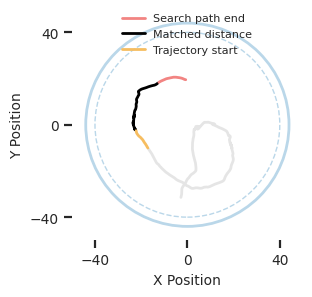

In [ ]:
fig, ax = plt.subplots(figsize=(3,3))
plot_search_path_two_trials(ax,randomNess=False)

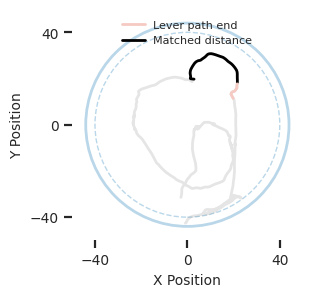

In [ ]:
fig, ax = plt.subplots(figsize=(3,3)) 
plot_lever_path_two_trials(ax,randomNess=False)

# Perhaps an even more detailed explaination is needed

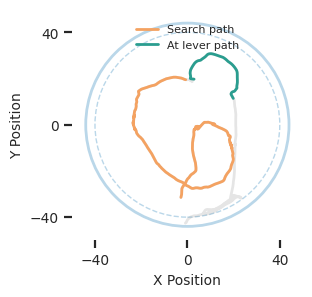

In [ ]:
import random
sns.set(rc={"figure.dpi":100, 'savefig.dpi':100})
sns.set_theme(style = 'ticks')

def plot_search_lever_path(ax):
    
    leverEndColor = ['#F5CAC3']
    
    SEARCHCOLOR = '#f4a261'
    LEVERCOLOR = '#2a9d8f'
        
    testSession = 'jp486-18032023-0108'
    lw = 2
    
    sessionSlice = matchedDistanceDf_d[matchedDistanceDf_d.session == testSession].copy()

    plotDf1 = sessionSlice[(sessionSlice.condition == 'atLever_dark') & (sessionSlice.withinTrialSplit == 'Q1')].copy()
    plotDf3 = sessionSlice[(sessionSlice.condition == 'atLever_dark') & (sessionSlice.withinTrialSplit == 'Q4')].copy()
    plotDf4 = sessionSlice[(sessionSlice.condition == 'atLever_dark') & (sessionSlice.withinTrialSplit.isin(['Q3','Q2']))].copy()
    plotAll = allSessionDf[(allSessionDf.condition == 'all_dark')&(allSessionDf.session == testSession)].copy()
    
    plotS = allSessionDf[(allSessionDf.condition == 'searchToLeverPath_dark')&(allSessionDf.session == testSession)].copy()
    
    plotL = allSessionDf[(allSessionDf.condition == 'atLever_dark')&(allSessionDf.session == testSession)].copy()
    


    selectedTrials = [60]
        
    

    for t in selectedTrials:
        ax.plot(
                plotAll[plotAll.trialNo == t]['xPose'],plotAll[plotAll.trialNo == t]['yPose'],color='gray',linewidth=lw,alpha=0.2
            )
        
    for t in selectedTrials:
        ax.plot(
                plotS[plotS.trialNo == t]['xPose'],plotS[plotS.trialNo == t]['yPose'],color=SEARCHCOLOR,linewidth=lw,alpha=1
            )
        
    for t in selectedTrials:
        ax.plot(
                plotL[plotL.trialNo == t]['xPose'],plotL[plotL.trialNo == t]['yPose'],color=LEVERCOLOR,linewidth=lw,alpha=1 #
            )
        
    
    ax.set_xlabel('X Position',fontsize=GLOBALFONTSIZE)
    ax.set_ylabel('Y Position',fontsize=GLOBALFONTSIZE)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    ax.set_xlim(-44, 44)
    ax.set_ylim(-0, 44)

    custom_ticks = [-40, 0, 40]
    ax.set_xticks(custom_ticks)
    ax.set_yticks(custom_ticks)
    ax.tick_params(
        axis="both",
        which="both",
        labelsize=GLOBALFONTSIZE,
        width=GLOBALTICKWIDTH,
        length=GLOBALTICKLENGTH,
    )

    draw_circle(ax)
    draw_circle(ax,r=40,lw=1,ls='dashed')
    
    legend_labels = ['Search path','At lever path']
    legend_colors = [SEARCHCOLOR,LEVERCOLOR]
    
    custom_legend = [plt.Line2D([],[],color=color, linestyle = '-',lw=lw) for color in legend_colors]
    
    ax.legend(custom_legend,legend_labels,fontsize= GLOBALFONTSIZE-2, frameon=False,loc='lower center', bbox_to_anchor = (0.5,0.78))
    
fig, ax = plt.subplots(figsize=(3,3))
plot_search_lever_path(ax)
    


# Calculate a within-trial difference

In [ ]:
def diff_abs_value(group):
    # Get the abs_value for each metric within the group.
    val1 = group.loc[group['metric'] == 'circMean_diff_l4_s4', 'abs_value']
    val2 = group.loc[group['metric'] == 'circMean_diff_Q4_Q1', 'abs_value']
    
    # Assuming each group has one of each metric.
    return val1.iloc[0] - val2.iloc[0]

# Apply the function to each group.
withinTrialSubtraction = matchedStatsDf_d.groupby(['session', 'trialNo']).apply(diff_abs_value).reset_index(name='difference')


In [ ]:
#fn = myProject.dataPath + '/results/within_trial_orientation_subtraction.csv'
#withinTrialSubtraction.to_csv(fn, index=False)

In [ ]:
def circular_mean_function(angles):
    """
    Compute the circular mean of an array of angles in radians.

    Parameters:
        angles (array-like): An array or list of angles in radians.
    
    Returns:
        float: The circular mean of the angles in radians.
    """
    angles = np.asarray(angles)
    # Compute the mean of the complex representations of the angles
    return np.angle(np.mean(np.exp(1j * angles)))

groupedPerSession = withinTrialSubtraction.groupby('session').agg({'difference': calculate_circular_mean}).reset_index()

In [ ]:
groupedPerSession['mouse'] = groupedPerSession['session'].apply(lambda x: x.split('-')[0])

In [ ]:
def p_value_to_asterisk(p_value):
    if p_value < 0.0001:
        return '****'
    elif p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return 'n.s.'
    
def plot_difference_histogram(ax,inputDf,xlabel='Lever ori. drift-\nDistance matched ori. drift',ylabel='Trials',c='black',bin_num=5):
    
    sns.histplot(data=inputDf,x='difference',ax=ax,color=c,bins=bin_num) 


    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(xlabel, fontsize=GLOBALFONTSIZE)
    ax.set_ylabel(ylabel, fontsize=GLOBALFONTSIZE)
    ax.set_xticks(ticks=[-np.pi, 0, np.pi])
    ax.set_xticklabels(["-$\pi$","0", "$\pi$"],fontsize=GLOBALFONTSIZE)
    ax.set_xlim(-np.pi,np.pi)
    
    stat_val, p_val = scipy.stats.wilcoxon(inputDf['difference'])
    
    N_num = len(inputDf['difference'])
    
    print(f'Stats = {stat_val}, p = {round(p_val,3)}')

    
    ax.text(0.05,0.9,f'N = {N_num}',transform=ax.transAxes,fontsize=GLOBALFONTSIZE)


In [ ]:
def plot_difference_histogram(ax, inputDf,
                              xlabel='Grid ori. drift at the lever -\ndistance matched ori. drift',
                              ylabel='Trials', c='black', bin_num=5):
    
    sns.histplot(data=inputDf, x='difference', ax=ax, color=c, bins=bin_num) 


    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(xlabel, fontsize=GLOBALFONTSIZE)
    ax.set_ylabel(ylabel, fontsize=GLOBALFONTSIZE)
    ax.set_xticks(ticks=[-np.pi, 0, np.pi])
    ax.set_xticklabels(["-$\pi$", "0", "$\pi$"], fontsize=GLOBALFONTSIZE)
    ax.set_xlim(-np.pi, np.pi)
    
    stat_val, p_val = scipy.stats.wilcoxon(inputDf['difference'])
    N_num = len(inputDf['difference'])
    print(f'Stats = {stat_val}, p = {round(p_val, 3)}')
    
    ax.text(0.05, 0.7, f'N = {N_num}', transform=ax.transAxes, fontsize=GLOBALFONTSIZE)
    
    ax.axvline(x=0, linestyle='--', color='black')
    
    # Define arrow endpoints (you can change these values if desired)
    left_arrow_end = -np.pi/1.2   # left arrow endpoint in data coords
    right_arrow_end = np.pi/1.2  # right arrow endpoint in data coords
    y_arrow = 0.83          # y-position in axes fraction (so it stays at the top)
    
    # Draw left arrow (arrow head will be at the left end)
    ax.annotate("",
                xy=(left_arrow_end, y_arrow), xytext=(-0.2, y_arrow),
                xycoords=('data', 'axes fraction'),
                arrowprops=dict(arrowstyle='->', linestyle='-', color='black', lw=1.2))
    
    # Draw right arrow (arrow head will be at the right end)
    ax.annotate("",
                xy=(right_arrow_end, y_arrow), xytext=(0.2, y_arrow),
                xycoords=('data', 'axes fraction'),
                arrowprops=dict(arrowstyle='->', linestyle='-', color='black', lw=1.2))
    
    # To place text above the arrows, we use a blended transform 
    # (data for x, axes fraction for y) so that the text stays at a fixed 
    # vertical position relative to the axes.
    from matplotlib.transforms import blended_transform_factory
    transform = blended_transform_factory(ax.transData, ax.transAxes)
    
    # Calculate midpoint positions for the text labels
    left_text_x = (-0.6 + left_arrow_end) / 2
    right_text_x = (0.6 + right_arrow_end) / 2
    text_y = y_arrow + 0.05  # a little above the arrow
    
    ax.text(left_text_x, text_y, "More drift in\nsearch path", transform=transform,
            ha='center', va='bottom', fontsize=GLOBALFONTSIZE-2)
    ax.text(right_text_x, text_y, "More drift in\nat lever path", transform=transform,
            ha='center', va='bottom', fontsize=GLOBALFONTSIZE-2)


Stats = 75741.0, p = 0.557


(0.0, 80.0)

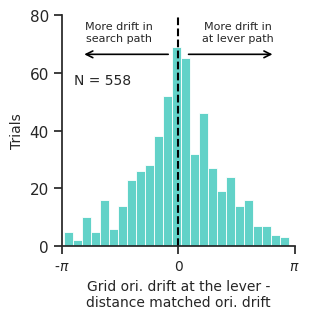

In [ ]:
fig, ax0 = plt.subplots(figsize=(3,3))
plot_difference_histogram(ax0,withinTrialSubtraction,c='#2EC4B6',bin_num=25)
ax0.set_ylim(0,80)

In [ ]:
def plot_avg_different_values(ax,inputDf,condition,val='mean_vector_length'):
    sns.lineplot(data=inputDf[(inputDf.condition == condition)],x='withinPathTime',y=val,ax=ax,c=circ_mvl_color_list[1]) #mean_vector_length
        
    ax.set_ylabel('Dir. precision',fontsize=GLOBALFONTSIZE)
    ax.set_xlabel('Time (s)',fontsize=GLOBALFONTSIZE)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    percentile_per_group = get_percentile_max(inputDf,percentile=0.8)
    percentileTime = percentile_per_group[percentile_per_group['condition'] == condition]['percentileTime'].values[0]

    ax.set_xlim(0,percentileTime)
    ax.set_ylim(0,1)

In [ ]:
df2

,session,condition,trialNo,circular_mean,mean_vector_length,withinPathTime
0,jp486-18032023-0108,all_dark,8,NaN,NaN,-1.24
1,jp486-18032023-0108,all_dark,8,NaN,NaN,-1.22
2,jp486-18032023-0108,all_dark,8,NaN,NaN,-1.20
3,jp486-18032023-0108,all_dark,8,NaN,NaN,-1.18
4,jp486-18032023-0108,all_dark,8,NaN,NaN,-1.16
...,...,...,...,...,...,...
88012,jp486-18032023-0108,searchToLeverPath_light,152,0.671165,0.640587,43.84
88013,jp486-18032023-0108,searchToLeverPath_light,152,0.648538,0.635951,43.86
88014,jp486-18032023-0108,searchToLeverPath_light,152,0.623192,0.632830,43.88
88015,jp486-18032023-0108,searchToLeverPath_light,152,0.590755,0.633418,43.90


(-2.0, 2.0)

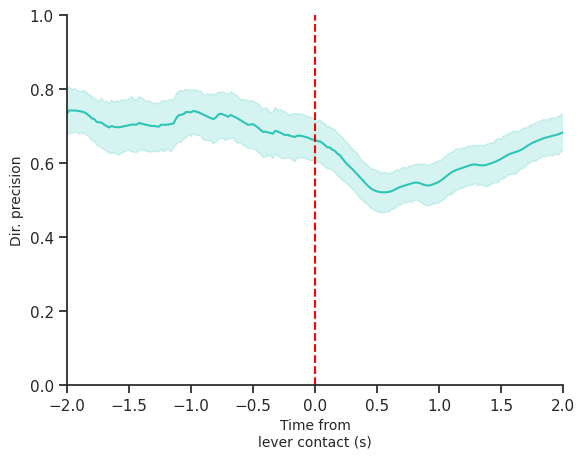

In [ ]:
fig, ax =plt.subplots()
plot_avg_different_values(ax,df2,'all_dark')
ax.axvline(x=0,ymax=1,color='red',ls='--') # NOTE LEVER CONTACT TIME
ax.set_xlabel('Time from\nlever contact (s)',fontsize=GLOBALFONTSIZE)
ax.set_xlim(-2,2)

In [ ]:
import pandas as pd

# Reset the main DataFrame index to ensure uniqueness
df_avg_speed = adjAllSessionDf.copy().reset_index(drop=True)

# Convert withinPathTime to a timedelta
df_avg_speed['time_delta'] = pd.to_timedelta(df_avg_speed['withinPathTime'], unit='s')

# Sort the DataFrame for proper rolling window computation
df_avg_speed.sort_values(['session', 'trialNo', 'condition', 'time_delta'], inplace=True)

window_size = pd.Timedelta(seconds=1)

def moving_average(grp):
    # No need to reset index here since it's unique already
    grp['speed_moving_avg'] = grp.rolling(window=window_size, on='time_delta', min_periods=20)['speed'].median()
    return grp

# Group by the desired columns and apply the moving average function
df_avg_speed = df_avg_speed.groupby(['session', 'trialNo', 'condition']).apply(moving_average)


In [ ]:
testSession = 'jp486-18032023-0108'

plot_df = df_avg_speed[
        (df_avg_speed.condition == "all_dark")
        & (df_avg_speed.session == testSession)
    ].copy()


In [ ]:
plot_df = plot_df.loc[:,['mouse','session','trialNo','condition','withinPathTimeAdj','speed','speed_moving_avg']].sort_values('withinPathTimeAdj').reset_index(drop=True)

In [ ]:
plot_df

,mouse,session,trialNo,condition,withinPathTimeAdj,speed,speed_moving_avg
0,jp486,jp486-18032023-0108,155,all_dark,-30.52,NaN,NaN
1,jp486,jp486-18032023-0108,155,all_dark,-30.50,16.721662,NaN
2,jp486,jp486-18032023-0108,155,all_dark,-30.48,19.382003,NaN
3,jp486,jp486-18032023-0108,155,all_dark,-30.46,21.966721,NaN
4,jp486,jp486-18032023-0108,155,all_dark,-30.44,24.378558,NaN
...,...,...,...,...,...,...,...
36208,jp486,jp486-18032023-0108,155,all_dark,32.88,3.491822,3.554816
36209,jp486,jp486-18032023-0108,155,all_dark,32.90,3.592489,3.554816
36210,jp486,jp486-18032023-0108,155,all_dark,32.92,3.612164,3.554816
36211,jp486,jp486-18032023-0108,155,all_dark,32.94,3.531286,3.549420


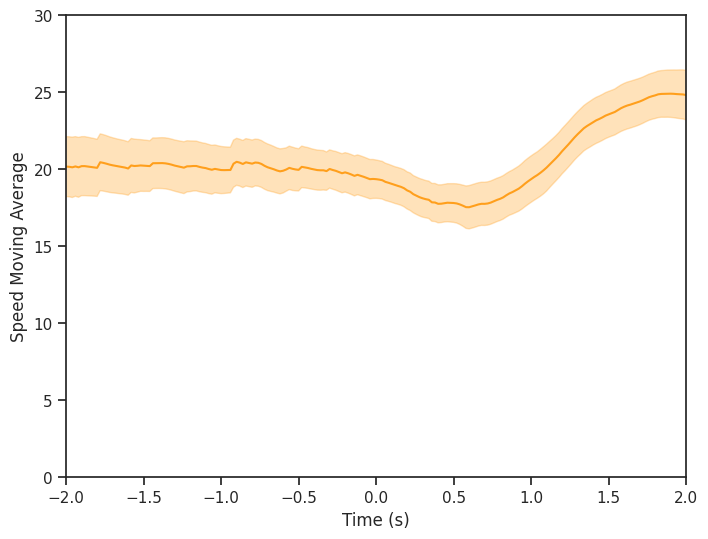

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def plot_average_speed_for_one_session(ax, inputDf, bin_interval=0.1):

    # Bin the time values to the nearest 0.1 second.
    inputDf["time_bin"] = (
        inputDf["withinPathTimeAdj"] / bin_interval
    ).round() * bin_interval

    # Group by the binned time and calculate the mean and SEM for speed_moving_avg.
    grouped = (
        inputDf.groupby("time_bin")
        .agg(mean_speed=("speed_moving_avg", "mean"), sem_speed=("speed_moving_avg", "sem"))
        .reset_index()
    )

    # Calculate the 95% confidence interval (approximately 1.96 * SEM).
    grouped["ci_lower"] = grouped["mean_speed"] - 1.96 * grouped["sem_speed"]
    grouped["ci_upper"] = grouped["mean_speed"] + 1.96 * grouped["sem_speed"]

    # Plot the aggregated line and fill between the CI limits.

    ax.plot(
        grouped["time_bin"], grouped["mean_speed"], color="#FF9F1C",
    )
    ax.fill_between(
        grouped["time_bin"],
        grouped["ci_lower"],
        grouped["ci_upper"],
        color="#FF9F1C",
        alpha=0.3,
        #label="95% CI",
    )
    ax.set_xlim(-2, 2)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Speed Moving Average")
    ax.set_ylim(0, 30)


fig, ax = plt.subplots(figsize=(8, 6))
plot_average_speed_for_one_session(
    ax,
    plot_df,
    bin_interval=0.02,
)

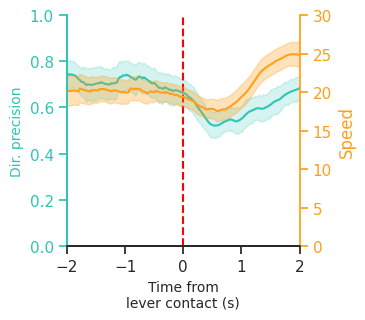

In [ ]:
# Create the main axis and the twin axis.
fig, ax_left = plt.subplots(figsize=(3, 3))
ax_right = ax_left.twinx()

# Plot the function for the left axis in red.
plot_avg_different_values(ax_left, df2, "all_dark")
# Optionally, add a vertical line (make sure the color fits your design)
ax_left.axvline(x=0, ymax=1, color="red", ls="--")
ax_left.set_xlabel("Time from\nlever contact (s)", fontsize=GLOBALFONTSIZE)
# Set left axis tick parameters and label color to red.
ax_left.tick_params(axis="y", colors="#2EC4B6")
ax_left.set_xlim(-2, 2)
# set a left y-axis label.
ax_left.set_ylabel("Dir. precision", color="#2EC4B6", fontsize=GLOBALFONTSIZE)

ax_left.spines['top'].set_visible(False)


# Plot the function for the right axis in blue.
plot_average_speed_for_one_session(
    ax_right,
    plot_df,
    bin_interval=0.02,
)
# Set right axis tick parameters and label color to blue.
ax_right.tick_params(axis="y", colors="#FF9F1C")
# set a right y-axis label.
ax_right.set_ylabel("Speed", color="#FF9F1C")
ax_right.set_ylim(0, 30)
ax_right.spines['top'].set_visible(False)

# Set the right spine color to blue.
ax_right.spines['right'].set_color('#FF9F1C')
# Set the left spine color to red.
ax_left.spines['left'].set_color('#2EC4B6')
ax_right.spines['left'].set_color('#2EC4B6')

### Add speed component

In [ ]:
fn = myProject.dataPath + '/results/reconstuctionDFOF.csv'
dfOF = pd.read_csv(fn,index_col=0)

In [ ]:
def vl_mvt_direction_error(mvtDirError):
    """
    Calculate the mean direction of the mvt direction error
    """
    xMean = np.mean(np.cos(mvtDirError))
    yMean = np.mean(np.sin(mvtDirError)) 
    return np.sqrt(xMean*xMean+yMean*yMean)

def get_mvl_at_speed(df,speed_min=0, speed_max=10):
    vl = vl_mvt_direction_error(df.mvtDirError[(df.speed>speed_min)&(df.speed<speed_max)])
    mid_speed = speed_min+(speed_max-speed_min)/2
    mouse = df.mouse.unique().item()
    res = pd.DataFrame({"vl": [vl],
                 "speed": [mid_speed],
                 "mouse": [mouse]})
    return res 
res_speed = []
for speed in [0, 5,10,15,20,25,30]:
    res_speed.append(dfOF.groupby(["session"]).apply(get_mvl_at_speed,speed,speed+5))

res_speed = pd.concat(res_speed).reset_index().drop(columns=["level_1"])

In [ ]:
res_speed = res_speed[res_speed.session.isin(useAble)].reset_index(drop=True)

In [ ]:
res_speed

,session,vl,speed,mouse
0,jp1686-26042022-0108,0.095493,2.5,jp1686
1,jp3120-25052022-0107,0.113953,2.5,jp3120
2,jp3120-26052022-0107,0.130232,2.5,jp3120
3,jp3269-28112022-0108,0.150956,2.5,jp3269
4,jp3269-29112022-0108,0.074096,2.5,jp3269
...,...,...,...,...
163,jp486-20032023-0108,0.673016,32.5,jp486
164,jp486-22032023-0108,0.842537,32.5,jp486
165,jp486-24032023-0108,0.872091,32.5,jp486
166,jp486-26032023-0108,0.650307,32.5,jp486


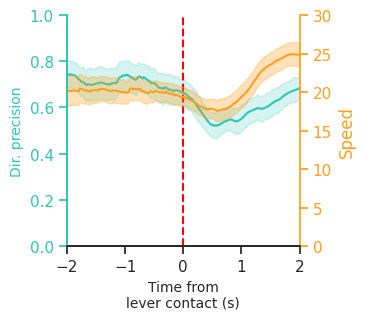

In [ ]:
# Create the main axis and the twin axis.
fig, ax_left = plt.subplots(figsize=(3, 3))


ax_right = ax_left.twinx()

# Plot the function for the left axis in red.
plot_avg_different_values(ax_left, df2, "all_dark")
# Optionally, add a vertical line (make sure the color fits your design)
ax_left.axvline(x=0, ymax=1, color="red", ls="--")
ax_left.set_xlabel("Time from\nlever contact (s)", fontsize=GLOBALFONTSIZE)
# Set left axis tick parameters and label color to red.
ax_left.tick_params(axis="y", colors="#2EC4B6")
ax_left.set_xlim(-2, 2)
# Optionally, set a left y-axis label.
ax_left.set_ylabel("Dir. precision", color="#2EC4B6", fontsize=GLOBALFONTSIZE)

ax_left.spines['top'].set_visible(False)


# Plot the function for the right axis in blue.
plot_average_speed_for_one_session(
    ax_right,
    plot_df,
    bin_interval=0.02,
)
# Set right axis tick parameters and label color to blue.
ax_right.tick_params(axis="y", colors="#FF9F1C")
# Optionally, set a right y-axis label.
ax_right.set_ylabel("Speed", color="#FF9F1C")
ax_right.set_ylim(0, 30)
ax_right.spines['top'].set_visible(False)

# Set the right spine color to blue.
ax_right.spines['right'].set_color('#FF9F1C')
# Set the left spine color to red.
ax_left.spines['left'].set_color('#2EC4B6')
ax_right.spines['left'].set_color('#2EC4B6')

# Final Final figure

In [ ]:
def plot_lever_on_axis(ax,lever_points1,lever_points2):
    ax.plot(lever_points1,lever_points2, color = "#525252",lw=2)

### Reorder the figure

In [ ]:
def plot_speed_with_mvl(ax0):
    ax_right = ax0.twinx()

    # Plot the function for the left axis in red.
    plot_avg_different_values(ax0, df2, "all_dark")
    # Optionally, add a vertical line (make sure the color fits your design)
    ax0.axvline(x=0, ymax=1, color="red", ls="--")
    ax0.set_xlabel("Time from\nlever contact (s)", fontsize=GLOBALFONTSIZE)
    # Set left axis tick parameters and label color to red.
    ax0.tick_params(axis="y", colors="#2EC4B6")
    ax0.set_xlim(-2, 2)
    # Optionally, set a left y-axis label.
    ax0.set_ylabel("Dir. precision", color="#2EC4B6", fontsize=GLOBALFONTSIZE)

    ax0.spines['top'].set_visible(False)


    # Plot the function for the right axis in blue.
    plot_average_speed_for_one_session(
        ax_right,
        plot_df,
        bin_interval=0.02,
    )
    # Set right axis tick parameters and label color to blue.
    ax_right.tick_params(axis="y", colors="#FF9F1C")
    # Optionally, set a right y-axis label.
    ax_right.set_ylabel("Speed (cm/sec)", color="#FF9F1C",fontsize=GLOBALFONTSIZE)
    ax_right.set_ylim(0, 30)
    ax_right.spines['top'].set_visible(False)

    # Set the right spine color to blue.
    ax_right.spines['right'].set_color('#FF9F1C')
    # Set the left spine color to red.
    ax0.spines['left'].set_color('#2EC4B6')
    ax_right.spines['left'].set_color('#2EC4B6')

In [ ]:
points_60_1 = [17.2569007 , 16.17523953,  7.10505529,  5.91917039,  9.26837762,
       18.33856187, 17.2569007 ]

    
points_60_2 = [21.64881309, 17.98626889, 20.66497133, 24.99719114, 27.99005973,
       25.31135729, 21.64881309]


points_147_1 = [-25.34017363, -28.89366358, -25.5203769 , -21.12356528,
       -18.413397  , -21.78668368, -25.34017363]

    
points_147_2 = [ -9.22916707,  -7.95590125,   1.45842543,   2.53874128,
        -1.08810621, -10.50243288,  -9.22916707]

Stats = 75741.0, p = 0.557
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

circMean_diff_l4_s4 vs. circMean_diff_Q4_Q1: Wilcoxon test (paired samples), P_val:9.664e-01 Stat=1.480e+02


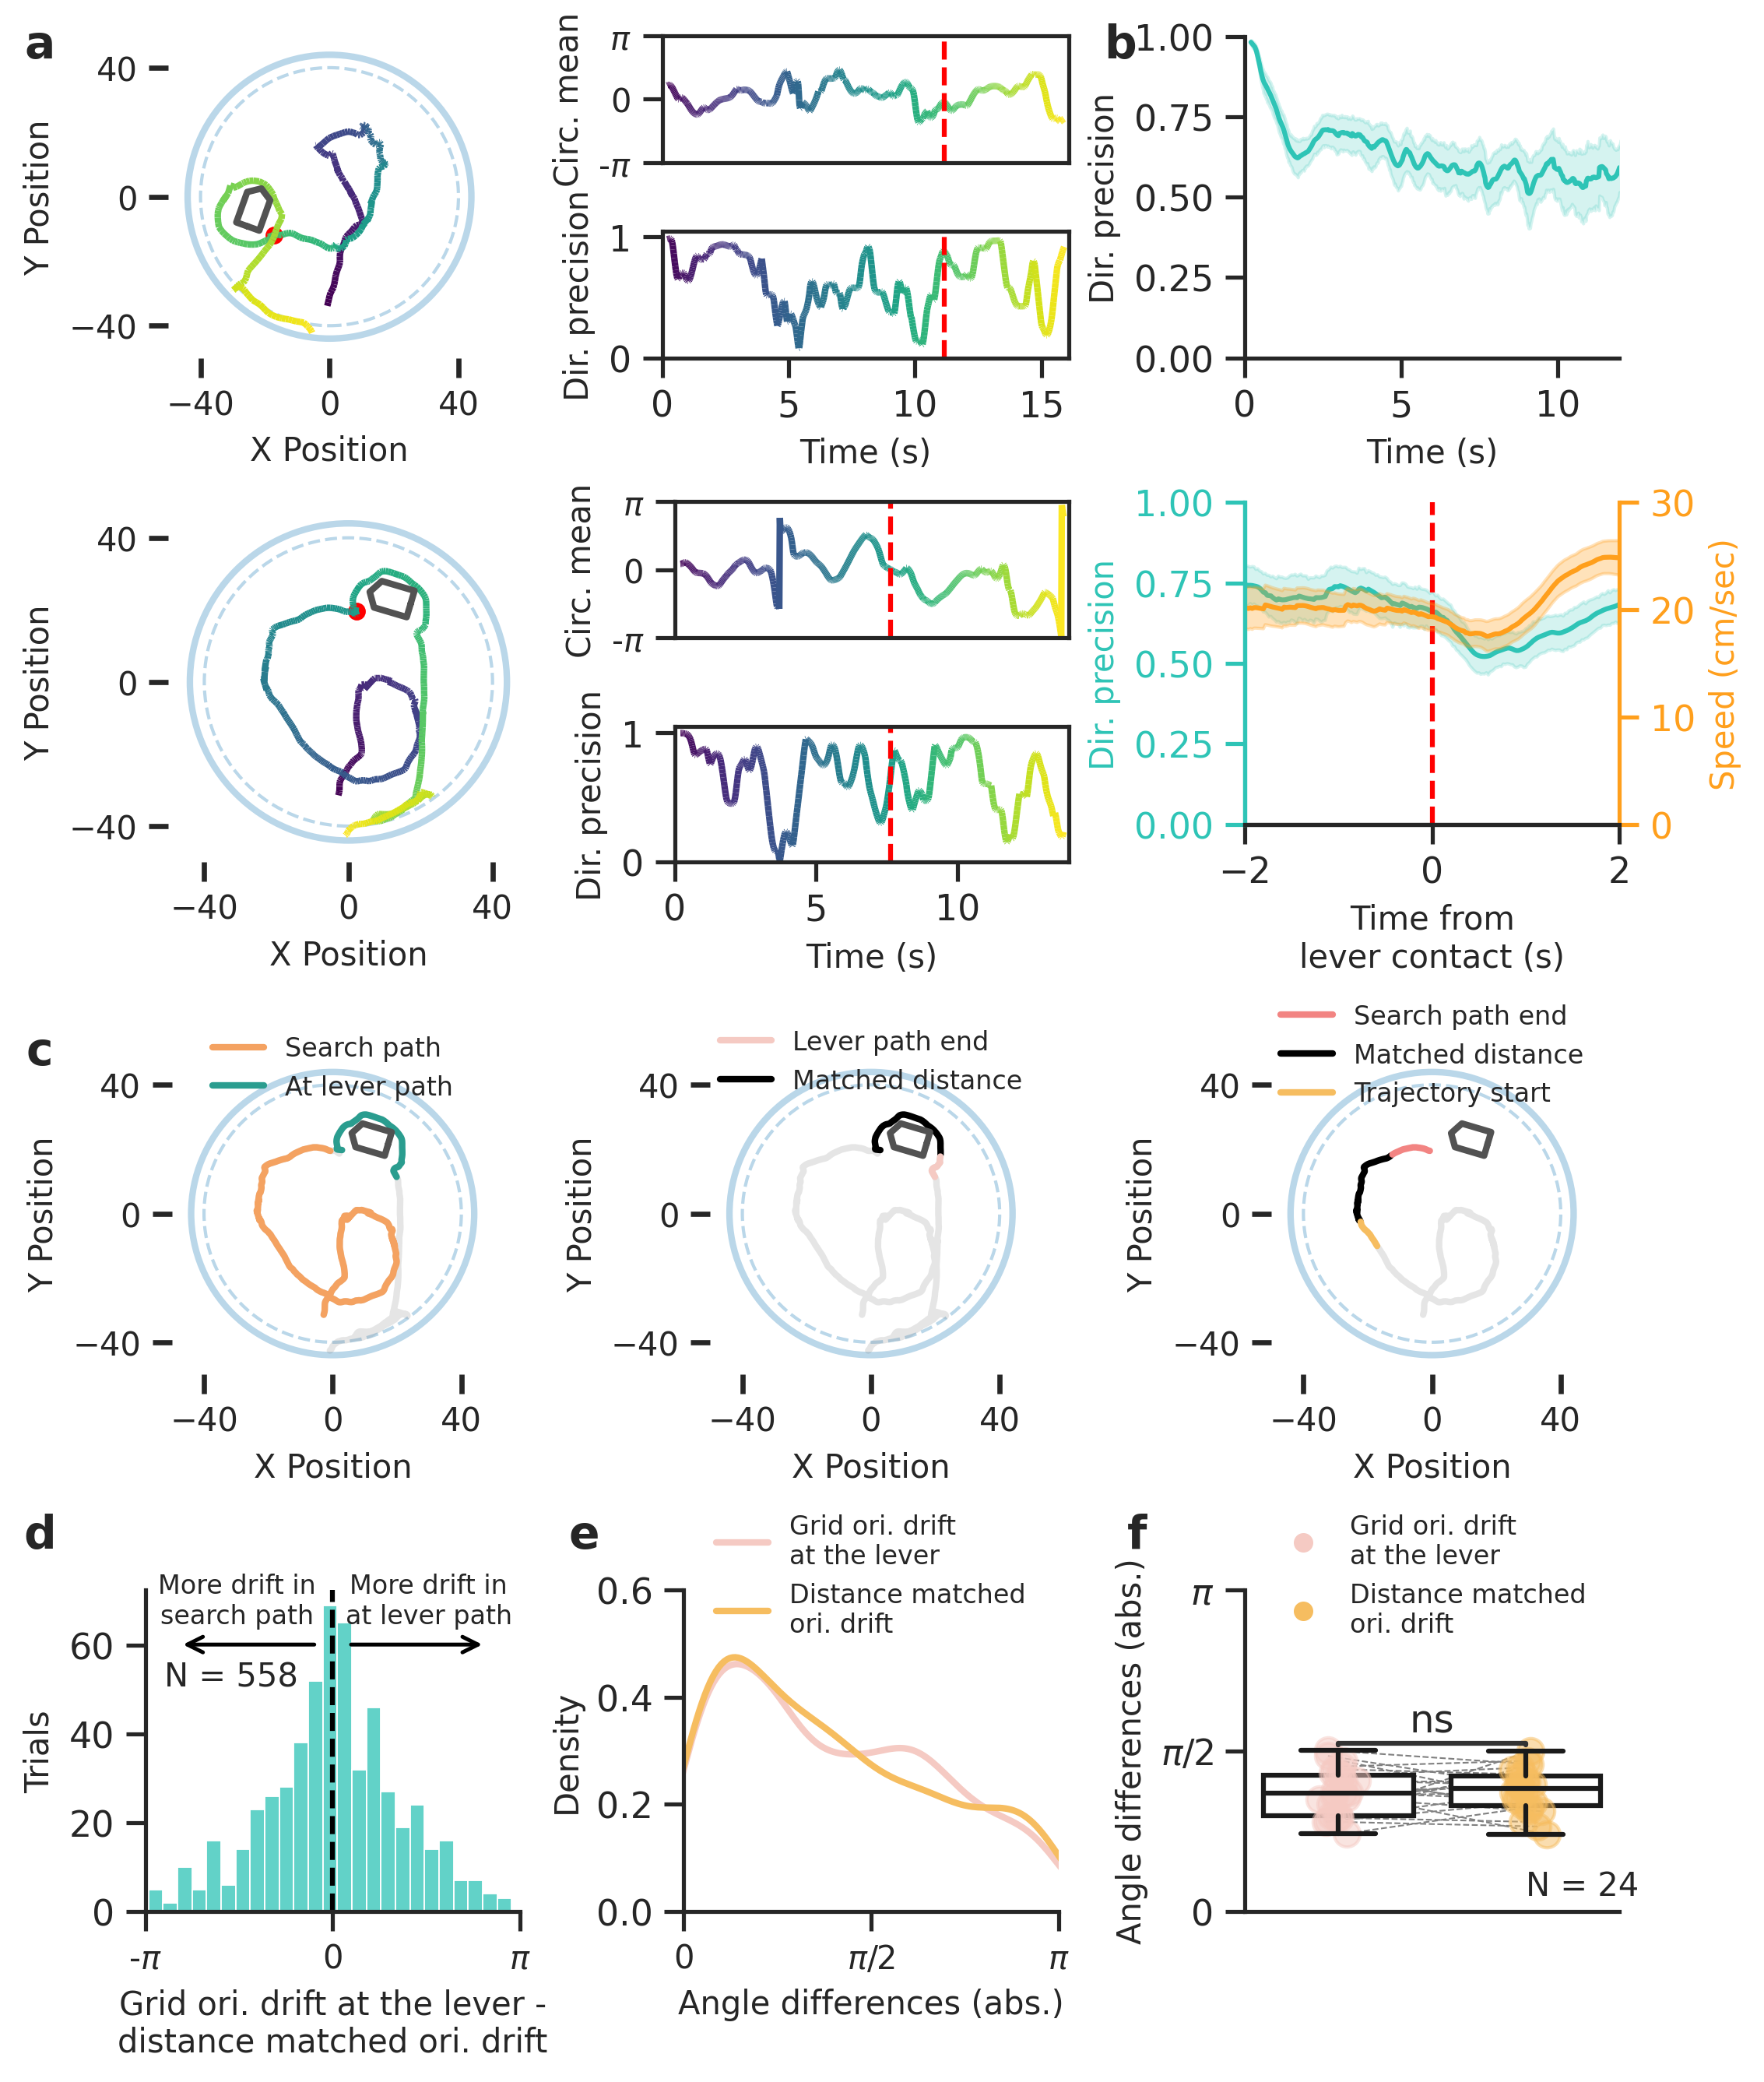

In [ ]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

nrows = 4
ncols = 3
colSize = 2.48
rowSize = 2.2
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

#Data Used For Making the Plot
sns.set_theme(style = 'ticks')

fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
gs = GridSpec(nrows,ncols,figure = fig)

gs_dark_example = GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0,:2])
gs_dark_example2 = GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[1,:2])


# NOTE PLOT DARK EXAMPLE
ax = fig.add_subplot(gs_dark_example[:,0])
cd = 'all_dark'
trial = 147
lTime = plot_animal_paths(ax,testSes,cd,trial)
plot_lever_on_axis(ax,points_147_1,points_147_2)

testSesSlice = testSes[(testSes.trialNo == trial)&(testSes.condition == cd)]

# Assuming withinPathTime is a numerical column
cmap = cm.viridis
norm = colors.Normalize(vmin=testSesSlice['withinPathTime'].min(),
                        vmax=testSesSlice['withinPathTime'].max())
ax = fig.add_subplot(gs_dark_example[0,1])
plot_circ_mean_per_trial(ax,df,cd,trialNo=trial,norm = norm,cmap=cmap,set_x=False)
ax.axvline(x=lTime,ymax=1,color='red',ls='--') 
ax.set_xticks([])
ax.set_xticklabels([])

ax = fig.add_subplot(gs_dark_example[1,1])
plot_mvl_avg_per_trial(ax,df,cd,trialNo=trial,norm = norm,cmap=cmap)
ax.axvline(x=lTime,ymax=1,color='red',ls='--') 

ax.set_xticks([0,5,10,15])
ax.set_xticklabels([0,5,10,15])



ax = fig.add_subplot(gs_dark_example2[:,0])
cd = 'all_dark'
trial = 60
lTime = plot_animal_paths(ax,testSes,cd,trial)
plot_lever_on_axis(ax,points_60_1,points_60_2)

testSesSlice = testSes[(testSes.trialNo == trial)&(testSes.condition == cd)]

cmap = cm.viridis
norm = colors.Normalize(vmin=testSesSlice['withinPathTime'].min(),
                        vmax=testSesSlice['withinPathTime'].max())
ax = fig.add_subplot(gs_dark_example2[0,1])
plot_circ_mean_per_trial(ax,df,cd,trialNo=trial,norm = norm,cmap=cmap,set_x=False)
ax.axvline(x=lTime,ymax=1,color='red',ls='--') 
ax.set_xticks([])
ax.set_xticklabels([])

ax = fig.add_subplot(gs_dark_example2[1,1])
plot_mvl_avg_per_trial(ax,df,cd,trialNo=trial,norm = norm,cmap=cmap)
ax.axvline(x=lTime,ymax=1,color='red',ls='--') 

ax.set_xticks([0,5,10])
ax.set_xticklabels([0,5,10])


# NOTE AVG MVL
ax = fig.add_subplot(gs[0,2])
plot_avg_mvl(ax,df,'all_dark')


# NOTE AVG MVL
ax = fig.add_subplot(gs[1,2])
plot_speed_with_mvl(ax)


# NOTE Add explanation subpanels
ax = fig.add_subplot(gs[2,0])
plot_search_lever_path(ax)
plot_lever_on_axis(ax,points_60_1,points_60_2)

ax = fig.add_subplot(gs[2,1])
plot_lever_path_two_trials(ax)
plot_lever_on_axis(ax,points_60_1,points_60_2)

ax = fig.add_subplot(gs[2,2])
plot_search_path_two_trials(ax)
plot_lever_on_axis(ax,points_60_1,points_60_2)

# NOTE DISTANCE MATCHED QUANTIFICATION
ax = fig.add_subplot(gs[3,0])
plot_difference_histogram(ax,withinTrialSubtraction,c='#2EC4B6',bin_num=25)

ax = fig.add_subplot(gs[3,1])
plot_distribution_plot(ax,matchedStatsDf_d,legend=True,ylim=0.6)

ax = fig.add_subplot(gs[3,2])
custom_stripplot_search_lever_split(ax,matchedStatsDfG_abs_d,customLegend=True)


gs1 = GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[:,:])
#***********************************#
ax0 = fig.add_subplot(gs1[:,:])

#Add figure legend
add_text(ax0,0,1,'a',fw='900')
add_text(ax0,0.635,1,'b',fw='900')

add_text(ax0,0,0.5,'c',fw='900')

add_text(ax0,0,0.26,'d',fw='900')
add_text(ax0,0.32,0.26,'e',fw='900')
add_text(ax0,0.645,0.26,'f',fw='900')

ax0.axis('off')
###

plt.savefig('../../Output/Sup_Figure6.pdf', bbox_inches='tight', dpi=300)